In [1]:
from pathlib import Path
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"


import pandas as pd
from PIL import Image

import torch
from torchvision import transforms

from torch import nn

from fastai.distributed import *
from fastai.vision.all import *

from accelerate import notebook_launcher
from accelerate.utils import write_basic_config

In [2]:
device = torch.device('cuda:0')

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [4]:
# write_basic_config()

In [5]:
data_dir = Path('data'); assert data_dir.exists()

In [6]:
categories = [cat for cat in os.listdir(data_dir) if not cat.startswith('.')]

categories, len(categories)

(['between',
  'inside',
  'front',
  'above',
  'outside',
  'around',
  'along',
  'towards',
  'behind',
  'off',
  'over',
  'below',
  'against',
  'around_surround',
  'beside',
  'against_leaning',
  'along_position',
  'onto',
  'up',
  'down',
  'among',
  'all_over'],
 22)

In [7]:
def noop(x): return x

In [8]:
from torch.utils.data import Dataset

class dataset(Dataset):
    def __init__(self, data_dir = data_dir, transform:list = None, y_transform:list = None, frames_per_vid=10, sampling = 'uniform'):
        f'''
        frames_per_vid: how many frames to consider per video for a data sample x. 
                        Per video, frames_per_vid images will be returned, using a sampling. Eg, if sampling = 'uniform', 10 uniformly spaced images will be returned. 
        sampling :      "uniform" by default, other values: "start", "end". if uniform, images will be uniformly returned (including the starting and ending images). If start, the first 10 images will be returned, 
                        if end, from the end
        '''
        super().__init__()
        self.data_dir = Path(data_dir)
        
        self.classes = [cat for cat in os.listdir(data_dir) if not cat.startswith('.')]
        self.class_to_index = {cat:i for i,cat in enumerate(self.classes)}
        self.index_to_class = {self.class_to_index[cat]:cat for cat in self.classes}
        
        self.c = len(self.classes)
        
        
        self.transforms = list(transform) if transform is not None else [noop]
        self.y_transforms = list(y_transform) if y_transform is not None else [lambda x: self.class_to_index[x]]
        
        self.frame_lim = frames_per_vid #only the last frames_per_vid 
        assert sampling in ('uniform', 'start', 'end'), f"invalid sampling technique. choose from 'uniform', 'start' or 'end'"
        self.sampling = sampling
        
        self.videos = []
        for category in self.classes: 
            self.videos.extend([(category,video) for video in set(pd.read_csv(self.data_dir/f'{category}/{category}.csv')['video_file_name'])])
        
    def __len__(self): return len(self.videos)
    
    def __getitem__(self, idx):
        #we iterate like, idx0 is the first video from class0, idx1 is first video from class1, idxn is the second video from class 0, assuming that there are n classes in total
#         print(idx) 
#         cat = self.classes[idx%self.c]
#         vid = list(set(df['video_file_name']))[idx//self.c]
        cat,vid = self.videos[idx]
        df = pd.read_csv(self.data_dir/f'{cat}/{cat}.csv')
        frames = [Path(self.data_dir/f'{cat}/rgb_images/{f}') for f in sorted(df[df['video_file_name']==vid]['image_file_name'], key = lambda f: int(Path(f).stem.split('_')[-1]))]
        
        convert_tensor = transforms.ToTensor()
        
        x=torch.stack([self.apply_tfm(convert_tensor(Image.open(frame))[:3], self.transforms) for frame in self.sample(frames)], axis=0)
        x=torch.transpose(x,1,0) #3d resnets expect the tensor to be of the type bs, channel, frames, height, width (weird but okay). Axes are numbered from the left end. ie, frames =0, channels =1, height = 2, width = 3
        y=self.apply_tfm(cat, self.y_transforms)
        return x,y
                         
                         
    def apply_tfm(self, x, tfm_list):
        for tfm in tfm_list: x = tfm(x)
        return x
                       
    def sample(self, frames):
        if self.sampling=='uniform': return [frames[int(i*(len(frames)-1)/(self.frame_lim-1))] for i in range(self.frame_lim) ]
        elif self.sampling=='start': return frames[:self.frame_lim]
        elif self.sampling=='end': return frames[len(frames)-self.frame_lim:]
        

In [9]:
data = dataset(data_dir); len(data)

1660

In [10]:
train_split = 0.8
train_ds, test_ds = torch.utils.data.random_split(data, [int(len(data)*train_split), len(data) - int(len(data)*train_split)])

In [11]:
from torch.utils.data import DataLoader

In [12]:
def get_batch_size(frames_per_vid, max_effective_batch_size = 100):
    bs_ideal = max_effective_batch_size//frames_per_vid
    #this value can be a batch_size, but we want the nearest lower power of 2 as the batch size for efficiency purposes
    pow=1
    while True:
        if pow*2<=bs_ideal: pow*=2
        else: return pow

In [13]:
#batch_size
bs = get_batch_size(data.frame_lim, max_effective_batch_size = 100)
bs

8

In [14]:
train_dl = DataLoader(train_ds, batch_size =bs , shuffle = True)
test_dl = DataLoader(test_ds, batch_size = 2*bs, shuffle = True)
dls = DataLoaders(train_dl, test_dl)

In [15]:
%time x,y = next(iter(train_dl))
x.shape, y

CPU times: user 6.84 s, sys: 785 ms, total: 7.63 s
Wall time: 418 ms


(torch.Size([8, 3, 10, 512, 512]), tensor([ 1, 10, 18, 19,  5, 15, 12,  4]))

# Model

In [16]:
# device = 'cuda:0'

In [17]:
import torchvision.models as models
r3d_18 = models.video.r3d_18(weights = 'KINETICS400_V1')
r3d_18.fc = nn.Linear(in_features = 512, out_features=data.c)
# r3d_18 = r3d_18.to(device)

In [18]:
r3d_18

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [19]:
#check if model pipeline is working
# r3d_18(x.to(device)).shape

In [20]:
# learn = Learner(dls, model = r3d_18.to(device), loss_func = CrossEntropyLossFlat())

In [21]:
# learn.lr_find()

In [22]:
#functionality to distribute training accross GPUS.
#taken from: https://docs.fast.ai/tutorial.distributed.html

# def train(num_epochs = 1, lr =1e-4):
#     dls = DataLoaders(train_dl, test_dl)
#     learn = Learner(dls, model = r3d_18.to(device), loss_func = CrossEntropyLossFlat())
    
    
#     with learn.distrib_ctx(sync_bn = False, in_notebook = True): learn.fit(num_epochs, lr=lr)
#     learn.export("learner/r3d18_warmup")

In [23]:
# notebook_launcher(train, num_processes = 2)

In [24]:
dls = DataLoaders(train_dl, test_dl)
learn = Learner(dls, model = r3d_18.to(device), loss_func = CrossEntropyLossFlat(), metrics = accuracy)
# learn.lr_find()

We've already estabilished that fit_one_cycle works good, now we need to find a stable paradigm for training the model from scratch

In [25]:
learn.fit_one_cycle(1, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.079680,0.734728,0.722892,07:01


SuggestedLRs(valley=0.0002290867705596611)

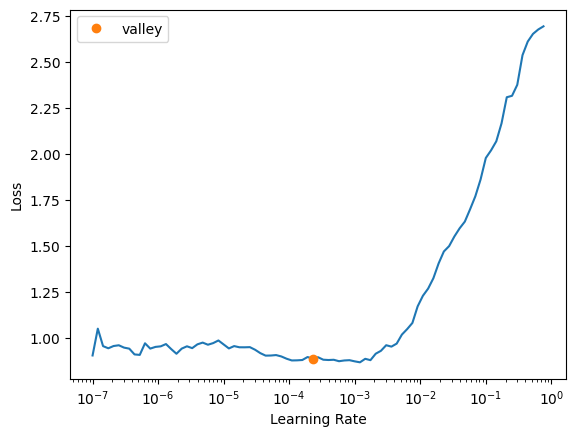

In [34]:
learn.lr_find()

In [26]:
learn.fit_one_cycle(5, 4e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.702522,2.990222,0.310241,07:01
1,0.539999,4.001996,0.138554,07:01
2,0.266091,0.249653,0.876506,07:01
3,0.226190,2.131598,0.692771,07:01
4,0.205689,0.192838,0.861446,07:01


In [27]:
learn.save('hoya1')

Path('models/hoya1.pth')

In [28]:
learn.load('hoya1')

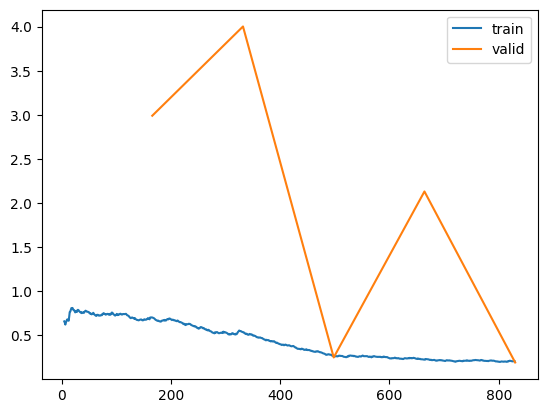

In [40]:
learn.recorder.plot_loss()

In [ ]:
learn.export("learner/r3d18_warmup_cycle")

how about I train for only 3 epochs and then redo lr_find

In [31]:
learn = Learner(dls, model = r3d_18.to(device), loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(3, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.927933,11.167295,0.120482,07:00
1,0.737097,17.440603,0.189759,07:02
2,0.564214,2.316667,0.457831,07:05


SuggestedLRs(valley=4.786300905834651e-06)

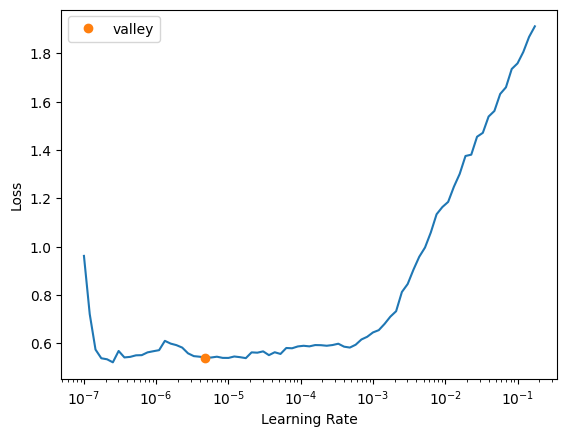

In [32]:
learn.lr_find()

In [36]:
learn.save("model_stage1", with_opt= True)
learn.load("model_stage1")

In [38]:
learn.fit(3, 2e-4)

epoch,train_loss,valid_loss,accuracy,time


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!